In [2]:
import bif_parser
import prettytable
import pydotplus
from IPython.core.display import Image
from bayesian.bbn import *

# Part 1 : Creation of Junction Tree

In [3]:
name = 'asia'
module_name = bif_parser.parse(name)
module = __import__(module_name)
bg = module.create_bbn()

In [4]:
def show_graphgiz_image(graphviz_data):
       graph = pydotplus.graph_from_dot_data(graphviz_data)
       graph.write_png('temp.png')
       return 'temp.png'

## Initial Bayesian Network

Bayesian Model : 


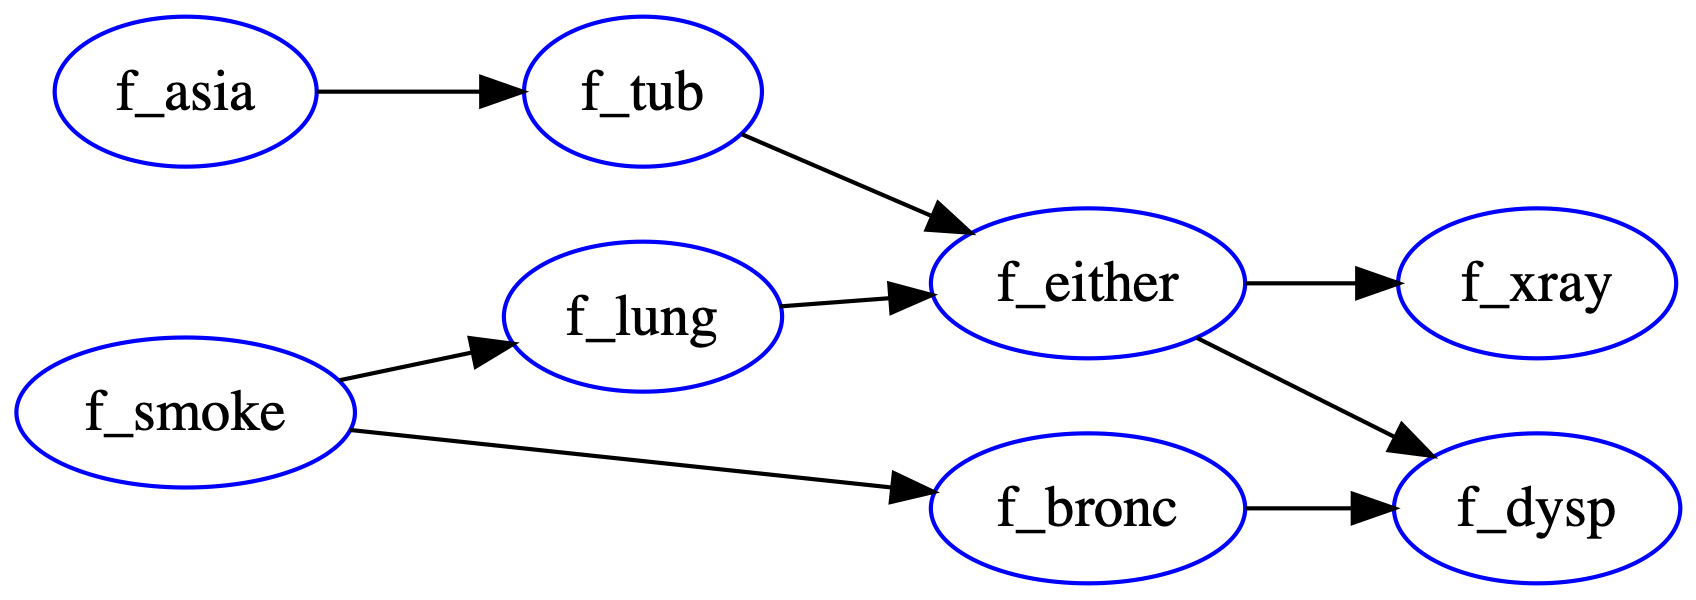

In [5]:
sf=bg.get_graphviz_source()
print "Bayesian Model : "
Image(filename=show_graphgiz_image(sf))


## Moralization of BN :
Here the Bayesian Network is converted into an undirected graph, by adding edges to cousin nodes.

Moralized Graph : 


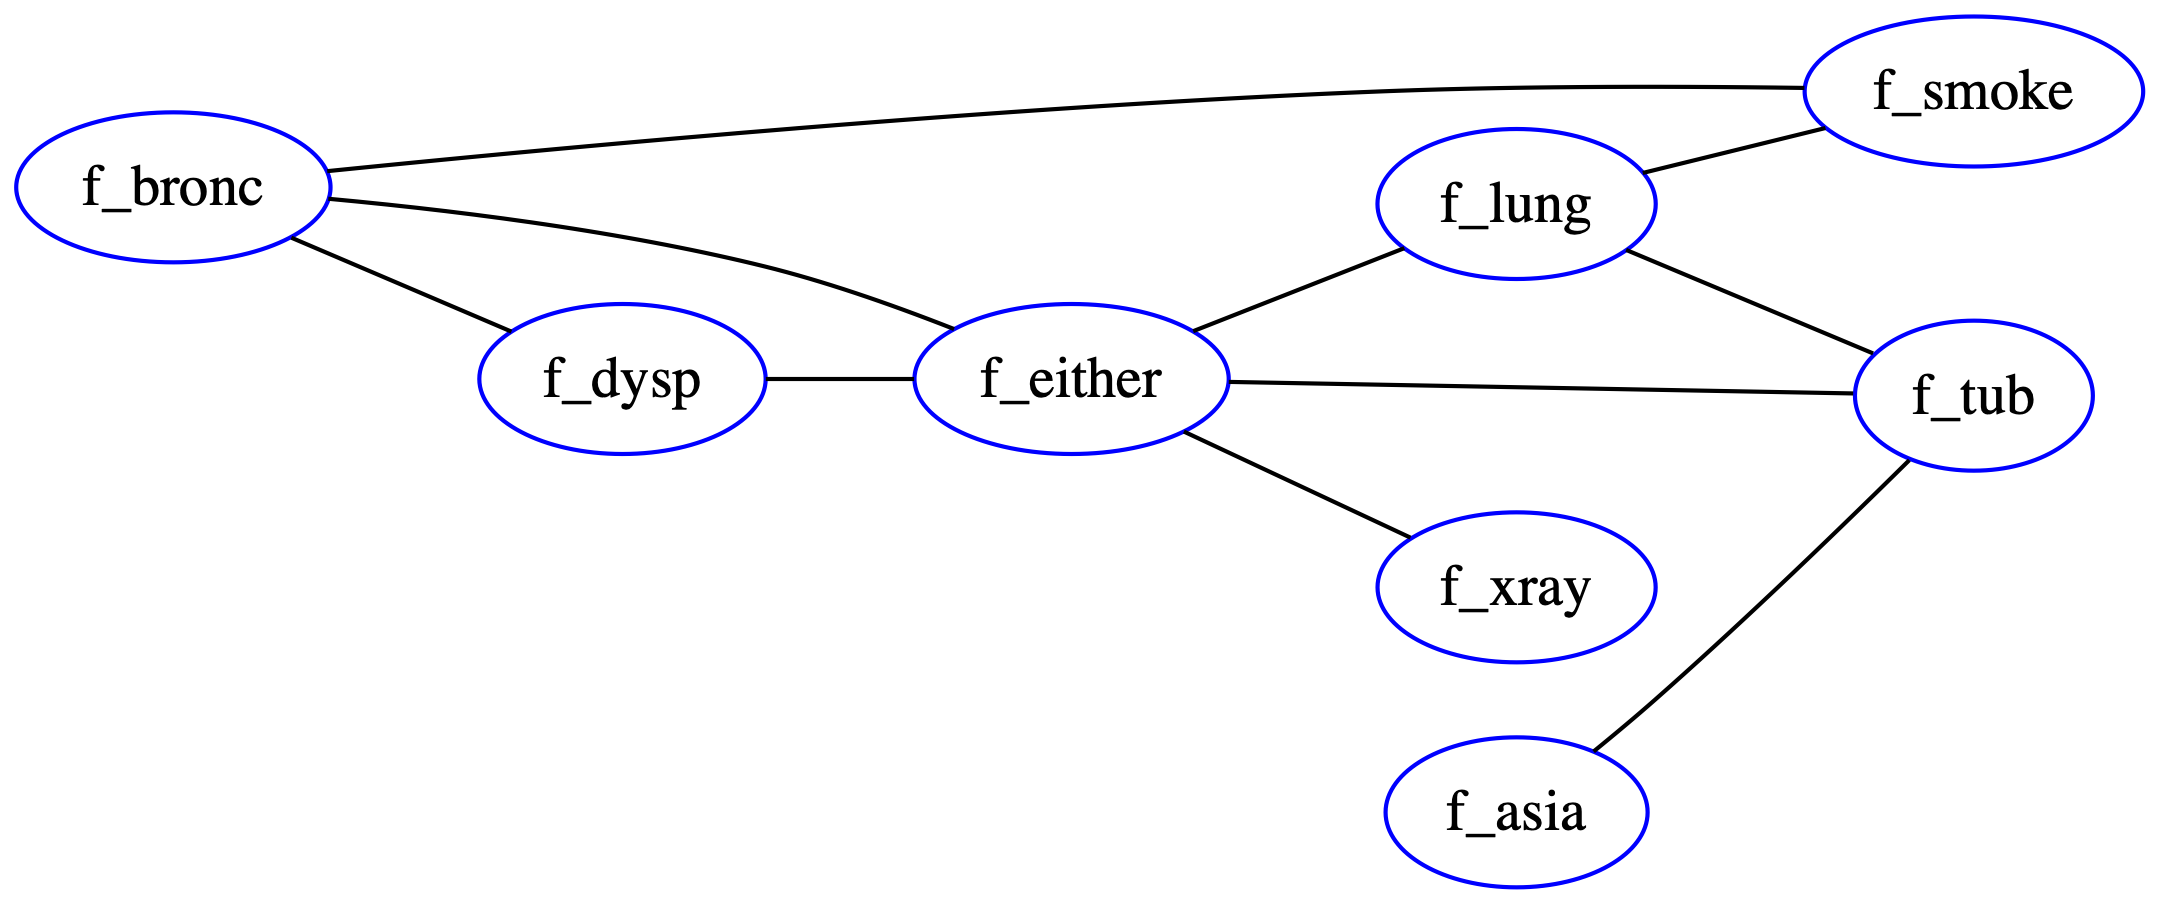

In [6]:
#moral graph
gu=make_undirected_copy(bg)
m1=make_moralized_copy(gu,bg)
s2=m1.get_graphviz_source()
print ("Moralized Graph : ")
Image(filename=show_graphgiz_image(s2))

## Triangulation of Graph
The moralized graph is then triangulated so as to make the maximum clique possible is 3. It adds edges if there is a cycle with more than 3 nodes.

Triangulated Graph : 


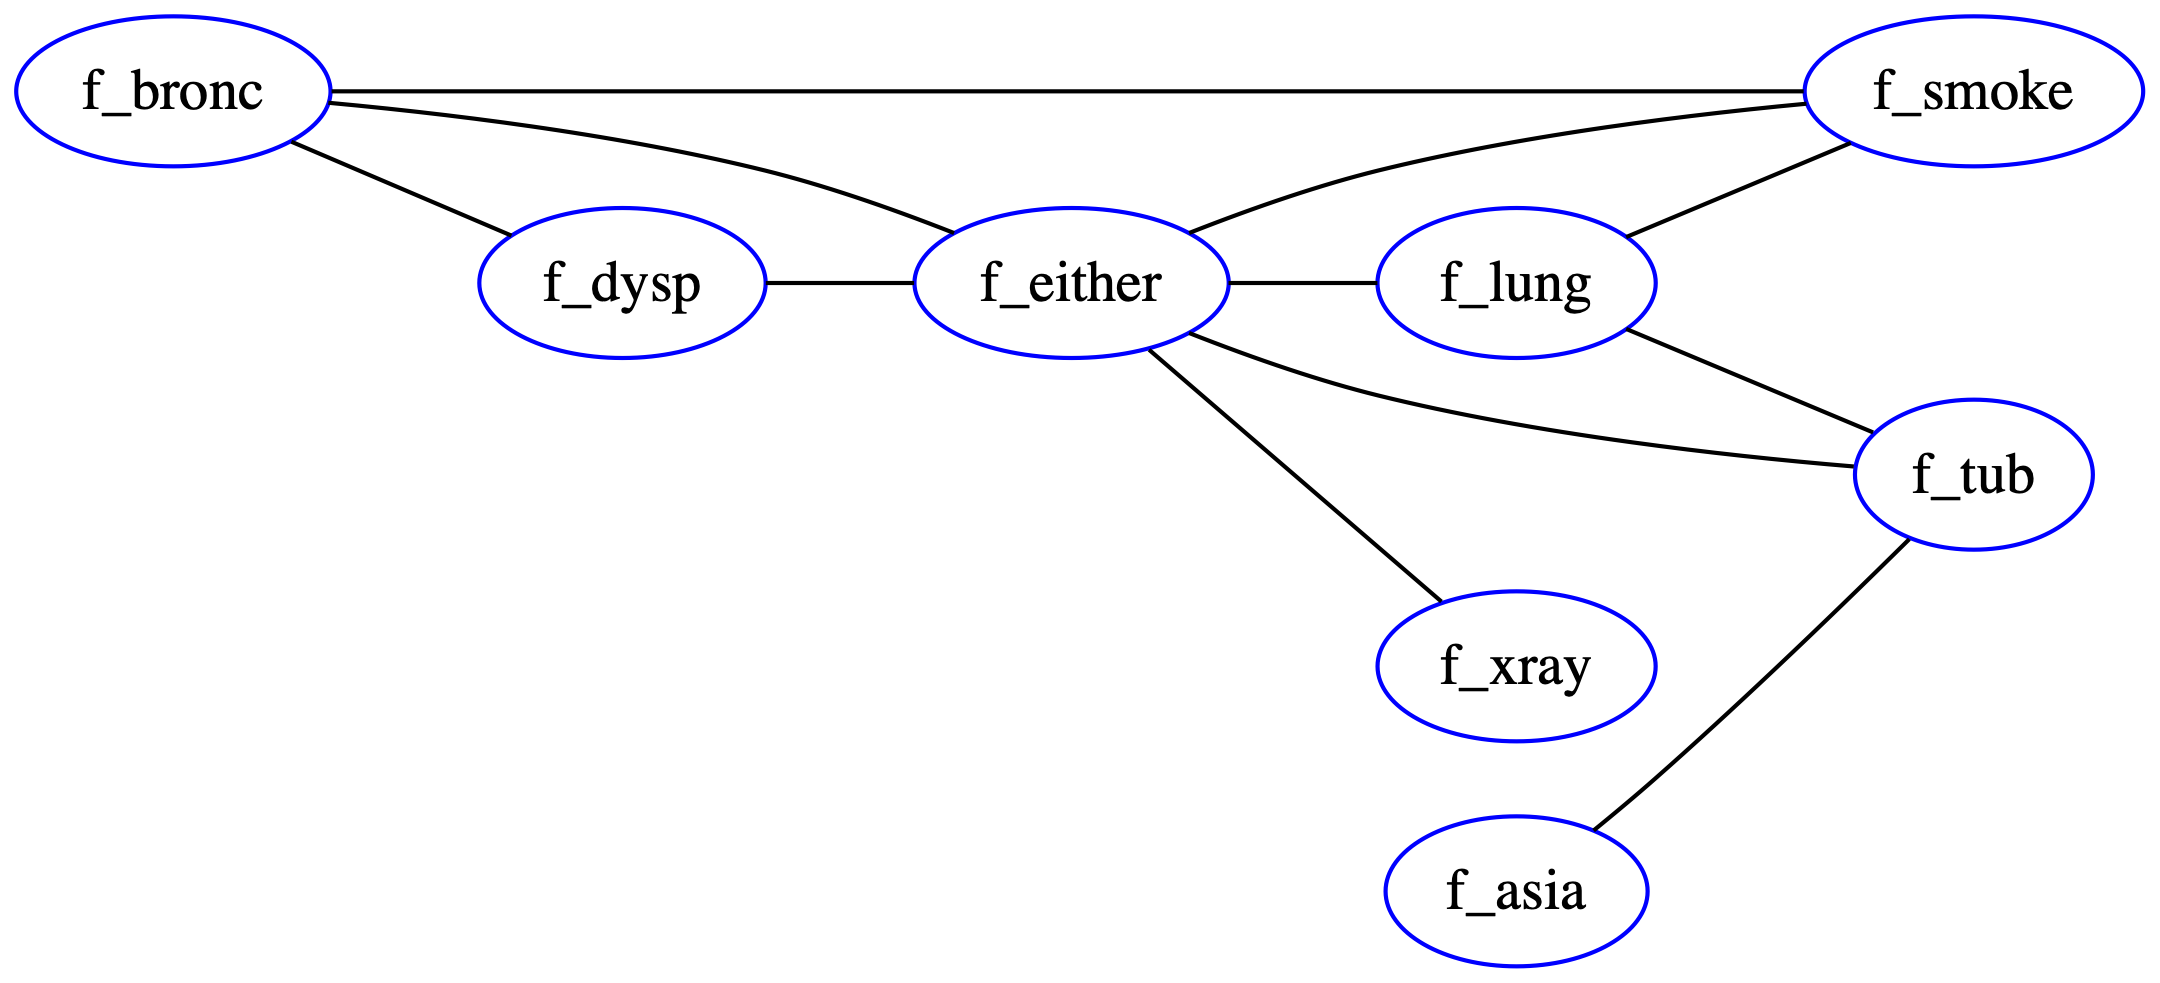

In [7]:
cliques, elimination_ordering = triangulate(m1, priority_func)
s2=m1.get_graphviz_source()
print ("Triangulated Graph : ")
Image(filename=show_graphgiz_image(s2))


## Junction Tree
The junction tree will classify each clique cluster as a node in the new tree. Each cluster is separated by some common node(s) which will act as the intersection between the clique clusters. This is used in message passing algorithm to update the marginal probabilities of the clusters.

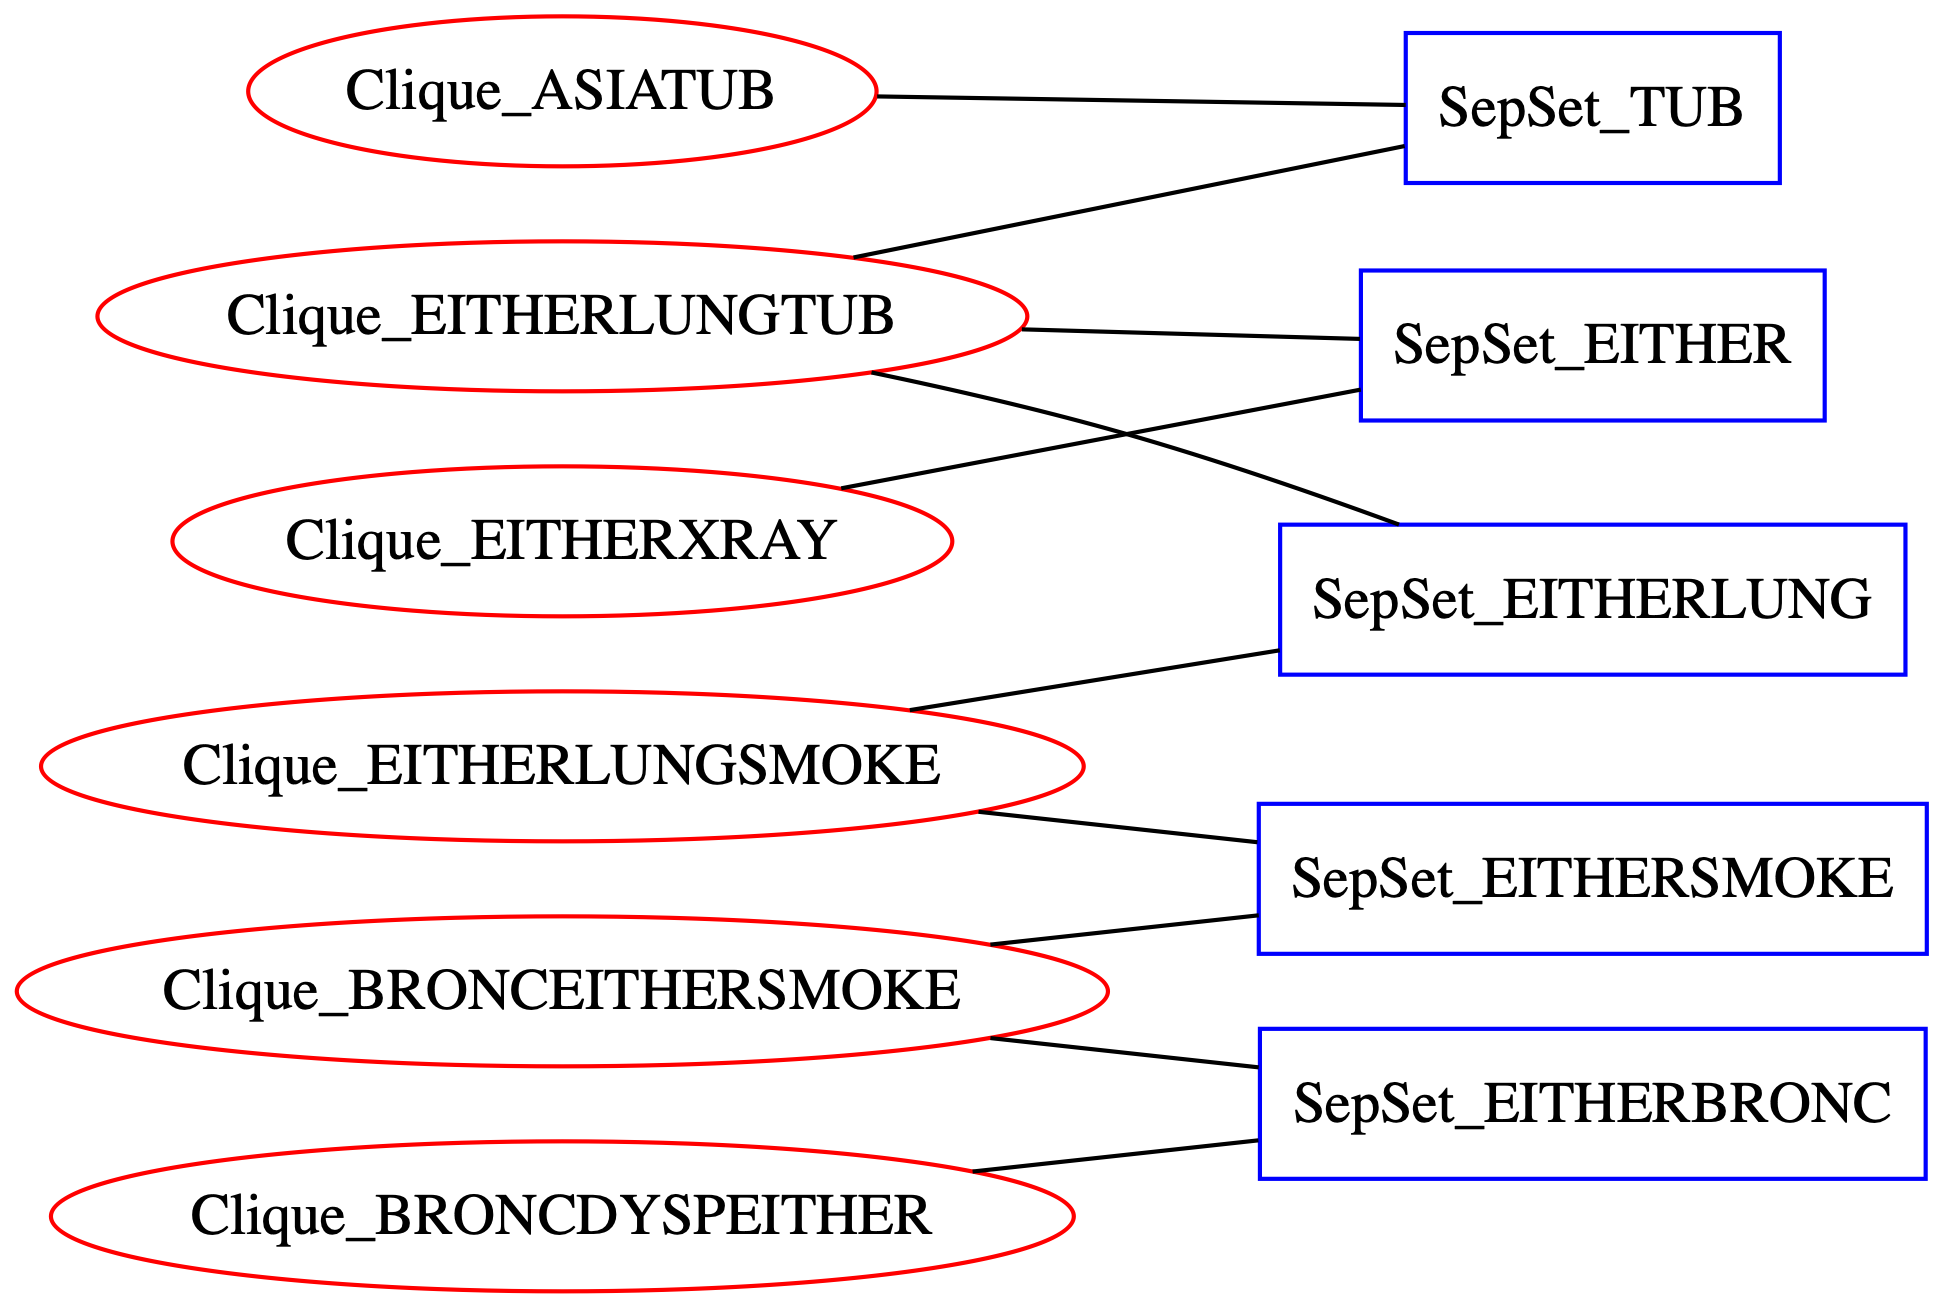

In [8]:
#building the join tree
jt=bg.build_join_tree()
sf=jt.get_graphviz_source()
Image(filename=show_graphgiz_image(sf))

## Running Intersection Property
The above junction tree satisfies the Running Intersection Property because if a variable is present in 2 clusters in the tree, then it is also present in all the cluster nodes that lie on the path between the 2 clusters. Since this is a tree, there can only be one single path between the clusters. 

We can take 'either' as an example. The node is present in 5 of the 6 clusters in the junction tree. So if we consider the clique(either, lung, tub) and clique(bronc, dysp, either), we have a path through 4 Separating Sets. In each of the separating sets, 'either' is present. This indicates that it satisfies the Running Intersection Property.

# Part 2 : Terms of p(V)
The terms p(a)p(t | a)p(s)p(l | s)p(b | s)p(e | t, l)p(d | e, b)p(x | e) can be represented in the graph for the following cluster nodes:

1. C(Asia, Tub) : p(a)p(t|a)
2. C(Either, Lung, Tub) : p(e|t,l) with t as the SepSet
3. C(Either, Lung, Smoke) : p(s)p(l|s)p(e|t,l) with l,e as the SepSet
4. C(Either, xray) : p(e|t,l)p(x|e)
5. C(Bronc, Either, Smoke) : p(s)p(b|s)p(e|t,l)
6. C(Bronc, Dysp, Either) : p(b|s)p(e|t,l)p(d|e,b)



In [9]:
#initializing potentials
assignments = jt.assign_clusters(bg)
jt.initialize_potentials(assignments,bg)

## Message Passing Algorithm
The message passing algorithm uses the clique potential representation to convert it into marginal distributions. The representation is called Clique Marginal Representation. The messages are passed twice through the set of cliques, ie inwards in the junction tree and subsequently passing messages in the other direction. It follows the first from the last clique in the RIP-ordering towards the first. 
The ordering makes sure that separating set node is contained in the neighbor of the cliques. After the nodes have updated the root node marginals, we send the messages from the root node towards the leaf nodes to change the marginals, but without changing the potentials. By doing so, the junction tree yields the clique marginal representation.
Hence the message passing algorithm gives the cluster marginals.

In [10]:
#Propogate to find the marginal representation
jt.propagate()

In [11]:
tub_clust=[i for i in jt.clique_nodes for v in i.variable_names if v=='tub']
print (" Marginal Representation of Clique(Asia, Tub) :")
tub_clust[0].potential_tt

 Marginal Representation of Clique(Asia, Tub) :


{(('asia', 'no'), ('tub', 'no')): 0.9801,
 (('asia', 'no'), ('tub', 'yes')): 0.0099,
 (('asia', 'yes'), ('tub', 'no')): 0.0095,
 (('asia', 'yes'), ('tub', 'yes')): 0.0005}

In [12]:
either_clust=[i for i in jt.clique_nodes for v in i.variable_names if v=='either']

In [13]:
print ("Marginal Representation of Clique(Bronc, Either, Dysp)")
either_clust[0].potential_tt

Marginal Representation of Clique(Bronc, Either, Dysp)


{(('bronc', 'no'), ('dysp', 'no'), ('either', 'no')): 0.46892195999999997,
 (('bronc', 'no'), ('dysp', 'no'), ('either', 'yes')): 0.008692680000000001,
 (('bronc', 'no'), ('dysp', 'yes'), ('either', 'no')): 0.05210244,
 (('bronc', 'no'), ('dysp', 'yes'), ('either', 'yes')): 0.020282920000000003,
 (('bronc', 'yes'), ('dysp', 'no'), ('either', 'no')): 0.08282951999999999,
 (('bronc', 'yes'), ('dysp', 'no'), ('either', 'yes')): 0.003585240000000001,
 (('bronc', 'yes'), ('dysp', 'yes'), ('either', 'no')): 0.33131807999999996,
 (('bronc', 'yes'), ('dysp', 'yes'), ('either', 'yes')): 0.03226716000000001}

In [15]:
print ("Marginal Representation of Clique(Bronc, Either, Smoke)")
either_clust[1].potential_tt

Marginal Representation of Clique(Bronc, Either, Smoke)


{(('bronc', 'no'), ('either', 'no'), ('smoke', 'no')): 0.34289639999999993,
 (('bronc', 'no'), ('either', 'no'), ('smoke', 'yes')): 0.178128,
 (('bronc', 'no'), ('either', 'yes'), ('smoke', 'no')): 0.0071036,
 (('bronc', 'no'), ('either', 'yes'), ('smoke', 'yes')): 0.021872000000000003,
 (('bronc', 'yes'), ('either', 'no'), ('smoke', 'no')): 0.1469556,
 (('bronc', 'yes'), ('either', 'no'), ('smoke', 'yes')): 0.267192,
 (('bronc', 'yes'), ('either', 'yes'), ('smoke', 'no')): 0.0030444,
 (('bronc', 'yes'), ('either', 'yes'), ('smoke', 'yes')): 0.032808000000000004}

In [16]:
print ("Marginal Representation of Clique(Either, Lung, Tub)")
either_clust[2].potential_tt

Marginal Representation of Clique(Either, Lung, Tub)


{(('either', 'no'), ('lung', 'no'), ('tub', 'no')): 0.935172,
 (('either', 'no'), ('lung', 'no'), ('tub', 'yes')): 0,
 (('either', 'no'), ('lung', 'yes'), ('tub', 'no')): 0,
 (('either', 'no'), ('lung', 'yes'), ('tub', 'yes')): 0,
 (('either', 'yes'), ('lung', 'no'), ('tub', 'no')): 0,
 (('either', 'yes'), ('lung', 'no'), ('tub', 'yes')): 0.009828000000000002,
 (('either', 'yes'), ('lung', 'yes'), ('tub', 'no')): 0.054428,
 (('either', 'yes'), ('lung', 'yes'), ('tub', 'yes')): 0.000572}

In [17]:
print ("Marginal Representation of Clique(Either, Lung, Smoke)")
either_clust[3].potential_tt

Marginal Representation of Clique(Either, Lung, Smoke)


{(('either', 'no'), ('lung', 'no'), ('smoke', 'no')): 0.48985199999999995,
 (('either', 'no'), ('lung', 'no'), ('smoke', 'yes')): 0.44532,
 (('either', 'no'), ('lung', 'yes'), ('smoke', 'no')): 0.0,
 (('either', 'no'), ('lung', 'yes'), ('smoke', 'yes')): 0.0,
 (('either', 'yes'), ('lung', 'no'), ('smoke', 'no')): 0.005148000000000001,
 (('either', 'yes'), ('lung', 'no'), ('smoke', 'yes')): 0.004680000000000001,
 (('either', 'yes'), ('lung', 'yes'), ('smoke', 'no')): 0.005,
 (('either', 'yes'), ('lung', 'yes'), ('smoke', 'yes')): 0.05}

In [18]:
print ("Marginal Representation of Clique(Either, Xray)")
either_clust[4].potential_tt

Marginal Representation of Clique(Either, Xray)


{(('either', 'no'), ('xray', 'no')): 0.8884133999999999,
 (('either', 'no'), ('xray', 'yes')): 0.046758600000000004,
 (('either', 'yes'), ('xray', 'no')): 0.00129656,
 (('either', 'yes'), ('xray', 'yes')): 0.06353144}